In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Necessary imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from PIL import Image
from IPython.display import display, clear_output
import ipywidgets as widgets
import io
from tqdm import tqdm


# **Loading Data**

In [ ]:
data_dir = ('/content/drive/MyDrive/5.Brain tumor project using CNN/brain tumor dataset/Training')
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
for i in categories:
  path = os.path.join(data_dir,i)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR) # Read as color
    img_array = cv2.resize(img_array, (224, 224)) # Resize to 224x224
    break
  break

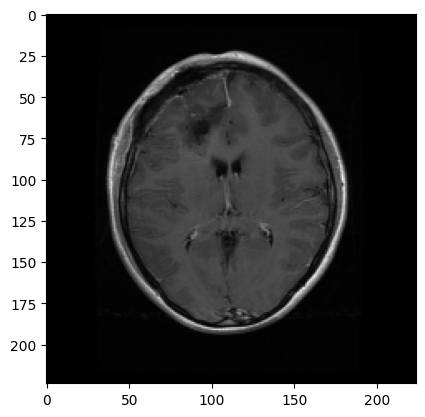

In [ ]:
plt.imshow(img_array,cmap='gray')

In [ ]:
img_array.shape


(224, 224, 3)

# **Displaying one image from each category**

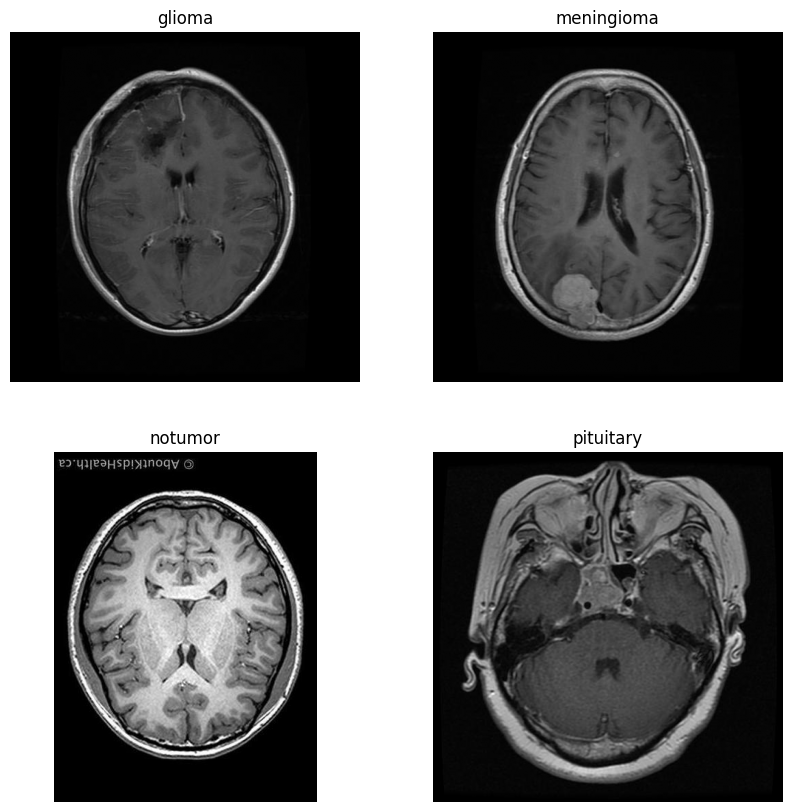

In [ ]:
# Displaying one image from each category
plt.figure(figsize=(10, 10))
for i, category in enumerate(categories):
    path = os.path.join(data_dir, category)
    img = os.listdir(path)[0]  # Get the first image in each category
    img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
    plt.subplot(2, 2, i + 1)
    plt.imshow(img_array,cmap='gray')
    plt.title(category)
    plt.axis('off')
plt.show()

In [ ]:
for category in categories:
    path = os.path.join(data_dir, category)
    num_images = len(os.listdir(path))
    print(f"Category '{category}': {num_images} images")

Category 'glioma': 1441 images
Category 'meningioma': 1465 images
Category 'notumor': 1830 images
Category 'pituitary': 1577 images


In [ ]:
img_array.shape

(224, 224, 3)

# **Apply DenseNet121 Model and Unfreeze The last 20 Layers**

In [ ]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121

input_shape = (224, 224, 3)
nb_classes = 4

# 1️⃣ Input layer
inputs = Input(shape=input_shape)

# 2️⃣ Base model (DenseNet121 without top layers, pre-trained on ImageNet)
base_model = DenseNet121(input_tensor=inputs, include_top=False, weights='imagenet')

# 3️⃣ Unfreeze the last 20 layers for training
for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

# 4️⃣ Add custom Dense + Dropout layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(nb_classes, activation='softmax')(x)

# 5️⃣ Build the Functional model
model = Model(inputs=inputs, outputs=outputs)



29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224), # Ensure target size matches model input
    batch_size=32,
    class_mode='categorical',
    subset='training',
    color_mode='rgb') # Ensure color images

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224), # Ensure target size matches model input
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    color_mode='rgb') # Ensure color images

Found 5051 images belonging to 4 classes.
Found 1262 images belonging to 4 classes.


In [ ]:
 # Use standard metrics

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,193,732 (27.44 MB)

 Trainable params: 523,396 (2.00 MB)

 Non-trainable params: 6,670,336 (25.45 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_checkpoint = ModelCheckpoint('BEST_model.keras', monitor='val_loss', save_best_only=True)
lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)


history = model.fit(train_generator,batch_size=32,epochs=200, validation_data=validation_generator, callbacks=[early_stopping, model_checkpoint,lr_callback])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
158/158 ━━━━━━━━━━━━━━━━━━━━ 1768s 11s/step - accuracy: 0.2525 - loss: 1.8674 - precision: 0.2649 - recall: 0.1696 - val_accuracy: 0.3423 - val_loss: 1.3353 - val_precision: 1.0000 - val_recall: 0.0063 - learning_rate: 1.0000e-05
Epoch 2/200
158/158 ━━━━━━━━━━━━━━━━━━━━ 703s 4s/step - accuracy: 0.2801 - loss: 1.4806 - precision: 0.3152 - recall: 0.0780 - val_accuracy: 0.5388 - val_loss: 1.2595 - val_precision: 1.0000 - val_recall: 0.0048 - learning_rate: 1.0000e-05
Epoch 3/200
158/158 ━━━━━━━━━━━━━━━━━━━━ 706s 4s/step - accuracy: 0.3189 - loss: 1.3756 - precision: 0.3820 - recall: 0.0717 - val_accuracy: 0.6204 - val_loss: 1.1965 - val_precision: 1.0000 - val_recall: 0.0135 - learning_rate: 1.0000e-05
Epoch 4/200
158/158 ━━━━━━━━━━━━━━━━━━━━ 695s 4s/step - accuracy: 0.4043 - loss: 1.2805 - precision: 0.5172 - recall: 0.0969 - val_accuracy: 0.6609 - val_loss: 1.1248 - val_precision: 0.9600 - val_recall: 0.0380 - learning_rate: 1.0000e-05
Epoch 5/200
158/158 ━━━━━━━━━━━━━━━━━━

**# Train and validation accuracy**
**# Train and validation loss**

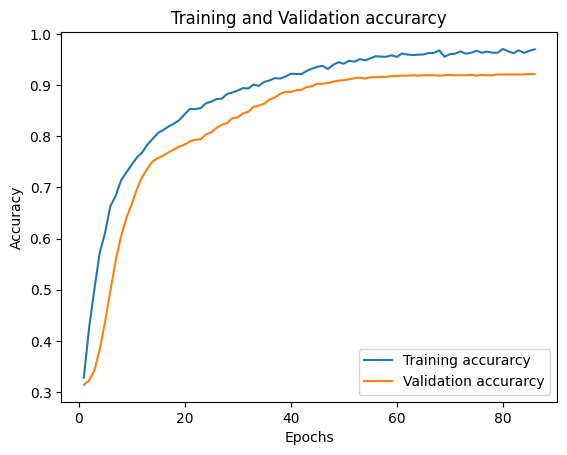

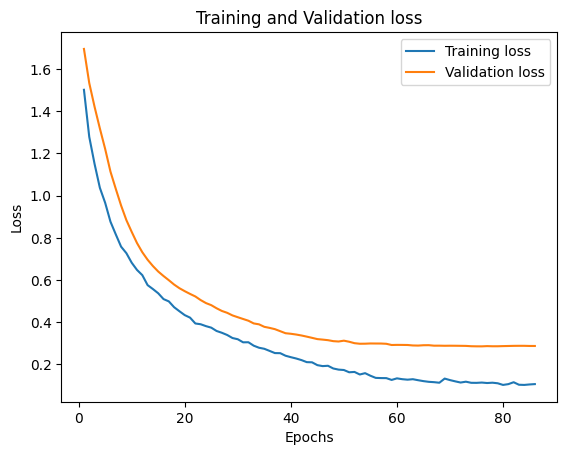

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, label='Training accurarcy')
plt.plot(epochs, val_acc, label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/BEST_model.keras')

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/5.Brain tumor project using CNN/brain tumor dataset/Testing',
    target_size=(224, 224), # Ensure target size matches model input
    batch_size=64,
    class_mode='categorical',
    color_mode='rgb')

Found 720 images belonging to 4 classes.


In [ ]:
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 399s 32s/step - accuracy: 0.9536 - loss: 0.1384 - precision: 0.9584 - recall: 0.9490
Test Accuracy: 0.9528
Test Loss: 0.1453
Test Precision: 0.9579
Test Recall: 0.9472
